In [206]:
from data_loader import load_latest_iteration, load_all_files

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [207]:
data_soft = load_latest_iteration(
    f"../code/cpp/build/src/growth_comparison_data/vtk_output_soft_1.000000e-02/data")
data_hard = load_latest_iteration(
    f"../code/cpp/build/src/growth_comparison_data/vtk_output_hard_1.000000e-02/data")

In [208]:
simulation_soft_all = load_all_files(
    f"../code/cpp/build/src/growth_comparison_data/vtk_output_soft_1.000000e-02/data", "simulation")
simulation_hard_all = load_all_files(
    f"../code/cpp/build/src/growth_comparison_data/vtk_output_hard_1.000000e-02/data", "simulation")

In [209]:
particles_soft = data_soft["particles"]
particles_hard = data_hard["particles"]
parameters_soft = data_soft["parameters"]
parameters_hard = data_hard["parameters"]


particles_soft.drop("lengths_y", axis=1, inplace=True)
particles_soft.drop("lengths_z", axis=1, inplace=True)
particles_soft.rename(columns={"lengths_x": "length"}, inplace=True)
particles_soft.rename(columns={"stress": "stress"}, inplace=True)

particles_hard.drop("lengths_y", axis=1, inplace=True)
particles_hard.rename(columns={"lengths_x": "length"}, inplace=True)
particles_hard.rename(columns={"stress": "stress"}, inplace=True)

In [210]:
particles_hard.rename(
    columns={c: c + " (hard)" for c in particles_hard.columns if c not in ["x", "y", "z"]}, inplace=True)
particles_soft.rename(
    columns={c: c + " (soft)" for c in particles_soft.columns if c not in ["x", "y", "z"]}, inplace=True)

simulation_hard_all.rename(
    columns={c: c + " (hard)" for c in simulation_hard_all.columns if c not in ["simulation_time_s"]}, inplace=True)
simulation_soft_all.rename(
    columns={c: c + " (soft)" for c in simulation_soft_all.columns if c not in ["simulation_time_s"]}, inplace=True)

In [211]:
lamdba_soft = data_soft["parameters"]["LAMBDA"][0]
lamdba_hard = data_hard["parameters"]["LAMBDA"][0]


if lamdba_soft == lamdba_hard:
    LAMBDA = f"{lamdba_soft:.0e}".replace("-", "M")
else:
    LAMBDA = f"{lamdba_soft:.0e}_{lamdba_hard:.0e}".replace("-", "M")
LAMBDA

'1eM02'

In [212]:
def spherocylinder_area(length, radius=0.25):
    """
    Calculate projected area of a spherocylinder
    Area = rectangle + 2 semicircles = 2*r*L + π*r²
    """
    return 2 * radius * (length-2*radius) + np.pi * radius**2


def compute_packing_fraction(shell_particles, r_inner, r_outer, mode="soft"):
    """
    Compute packing fraction of particles inside a radial shell.

    Args:
        shell_particles: DataFrame of particles within the shell
        r_inner: inner radius of the shell
        r_outer: outer radius of the shell
        mode: 'soft' or 'hard' (determines which length column to use)

    Returns:
        Packing fraction (float)
    """
    if len(shell_particles) == 0:
        return 0.0

    # Select length column
    length_col = 'length (soft)' if mode == "soft" else 'length (hard)'

    # Total particle area
    total_particle_area = sum(spherocylinder_area(length)
                              for length in shell_particles[length_col])

    # Shell area
    shell_area = np.pi * (r_outer**2 - r_inner**2)

    return total_particle_area / shell_area


def plot_radial_distribution(particles, variable, bin_size=1, fig=None):
    """
    Plot radial distribution of a variable.

    Args:
        particles: DataFrame containing particle data
        variable: String name of the variable to analyze or 
                  'packing_fraction (soft)' / 'packing_fraction (hard)'
        bin_size: Size of radial bins
        fig: Optional figure to plot on
    """
    # Calculate radial distances
    particles["dist_center"] = np.sqrt(
        particles["x"]**2 + particles["y"]**2 + particles["z"]**2
    )

    # Create radial bins
    max_radius = int(particles["dist_center"].max())
    r_edges = np.arange(0, max_radius + bin_size, bin_size)
    r_centers = (r_edges[1:] + r_edges[:-1]) / 2

    # Calculate values in each shell
    var_vals = []
    for i in range(len(r_centers)):
        mask = (particles["dist_center"] >= r_edges[i]) & (
            particles["dist_center"] < r_edges[i+1])
        shell_particles = particles[mask]

        if variable in ['packing_fraction (soft)', 'packing_fraction (hard)']:
            mode = "soft" if "soft" in variable else "hard"
            val = compute_packing_fraction(
                shell_particles, r_edges[i], r_edges[i+1], mode=mode)
        else:
            val = shell_particles[variable].mean() if len(
                shell_particles) > 0 else 0

        var_vals.append(val)

    var_vals = np.array(var_vals)

    # Create or get figure
    if fig is None:
        fig = plt.figure(figsize=(8, 5))
        ax = fig.add_subplot(111)
    else:
        ax = fig.axes[0]

    # Plot variable distribution
    if variable in ['packing_fraction (soft)', 'packing_fraction (hard)']:
        label = variable[0].upper() + variable[1:]
        ax.set_ylabel("Packing fraction", fontsize=14)
    else:
        label = variable[0].upper() + variable[1:]
        ax.set_ylabel(label.split(' ')[0], fontsize=14)

    ax.plot(r_centers, var_vals, "o-", label=label)
    ax.set_xlabel("Radius", fontsize=14)
    ax.set_title(
        f"Radial Distribution of {label.split(' ')[0]}", fontsize=14)
    ax.grid(True)
    ax.legend()

    fig.savefig(
        f"radial_distribution_combined_{LAMBDA}_{variable}.png", dpi=300)

    return fig, r_centers, var_vals

In [213]:
def plot_parameter_over_time(data, x, parameter, fig=None, rolling_window=None):
    if fig is None:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111)
    else:
        ax = fig.axes[0]

    x_data = data[x]
    y_data = data[parameter]

    # rolling window
    if rolling_window is not None:
        y_data = y_data.rolling(window=rolling_window).mean()
        x_data = x_data.rolling(window=rolling_window).mean()

    ax.plot(x_data, y_data, label=parameter)
    ax.set_xlabel(
        x, fontsize=13)
    ax.set_ylabel(parameter, fontsize=13)
    ax.set_title(f"{parameter.split(' ')[0]} over time", fontsize=13)
    ax.grid(True)
    ax.legend()

    fig.savefig(
        f"parameter_over_time_combined_{parameter.split(' ')[0]}.png", dpi=300)

    return fig

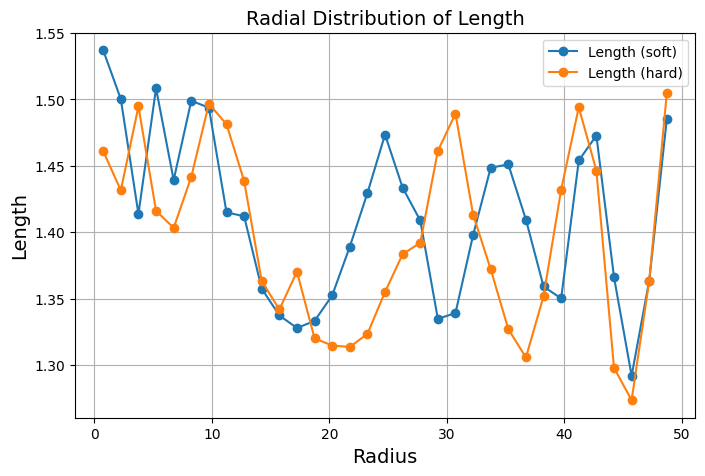

In [214]:
fig, r_centers, var_vals = plot_radial_distribution(
    particles_soft, "length (soft)", bin_size=1.5)

_ = plot_radial_distribution(particles_hard, "length (hard)", bin_size=1.5, fig=fig)

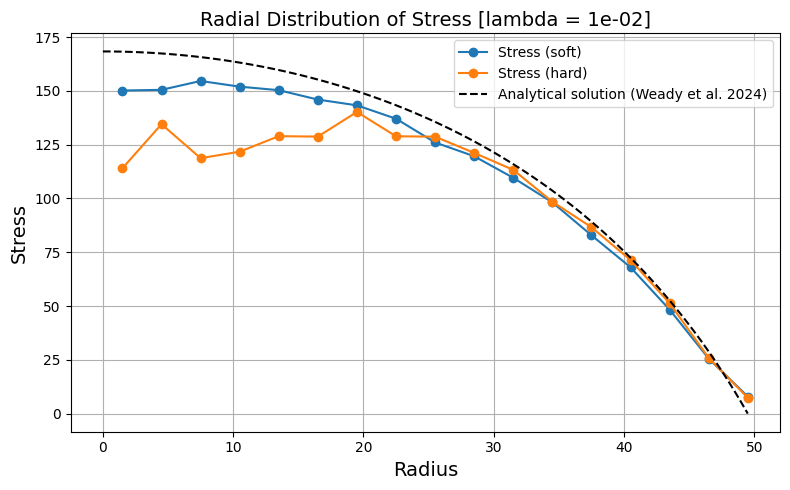

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


fig, bin_centers1, avg_val1 = plot_radial_distribution(particles_soft, "stress (soft)", bin_size=3)

fig, bin_centers2, avg_va2 =plot_radial_distribution(particles_hard, "stress (hard)", fig=fig, bin_size=3)


def pressure_theoretical(r, R, LAMBDA):
    c = (np.sqrt((1 + LAMBDA * R**2 / 2)) - 1) / (2 * LAMBDA * R**2)

    return 2 / LAMBDA * np.log(1/(8*c) - c * LAMBDA * r**2)


r1 = np.linspace(0, bin_centers1[-1], 100)
r2  = np.linspace(0, bin_centers2[-1], 100)

ax_stress = fig.axes[0]
ax_stress.plot(r1, pressure_theoretical(r1, bin_centers1[-1], data_soft["parameters"]["LAMBDA"][0]),
               label="Analytical solution (Weady et al. 2024)", color="black", linestyle="--")
# ax_stress.plot(r2, pressure_theoretical(r2, bin_centers2[-1], data_hard["parameters"]["LAMBDA"][0]),
#                label="Analytical solution (Weady et al. 2024)")
ax_stress.legend()

ax_stress.set_title(f"Radial Distribution of Stress [lambda = {data_soft['parameters']['LAMBDA'][0]:.0e}]", fontsize=14)

fig.tight_layout()
fig.savefig("radial_distribution_stress.png", dpi=300)



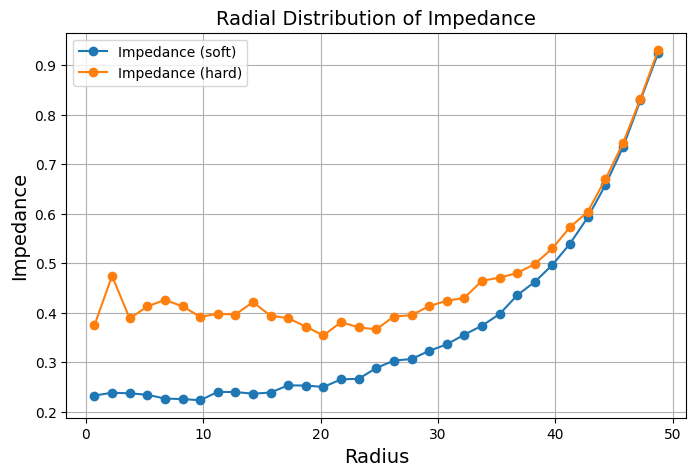

In [216]:

fig, bin_centers1, avg_val = plot_radial_distribution(particles_soft, "impedance (soft)", bin_size=1.5)

fig, bin_centers2, avg_val =plot_radial_distribution(particles_hard, "impedance (hard)", fig=fig, bin_size=1.5)

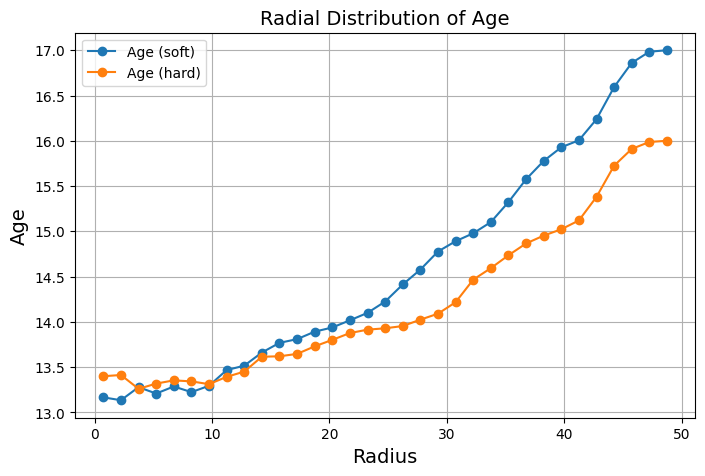

In [217]:

fig, bin_centers1, avg_val = plot_radial_distribution(particles_soft, "age (soft)", bin_size=1.5)

fig, bin_centers2, avg_val =plot_radial_distribution(particles_hard, "age (hard)", fig=fig, bin_size=1.5)

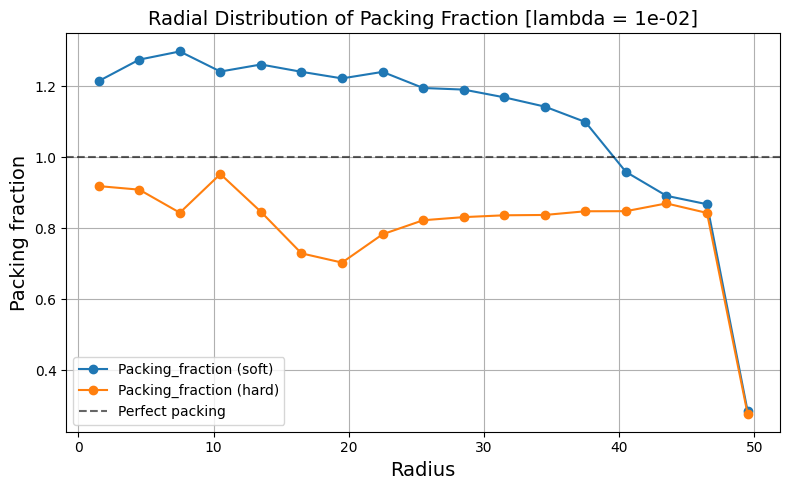

In [218]:
fig, bin_centers1, avg_val1 = plot_radial_distribution(particles_soft, "packing_fraction (soft)", bin_size=3)

fig, bin_centers2, avg_va2 =plot_radial_distribution(particles_hard, "packing_fraction (hard)", fig=fig, bin_size=3)



r1 = np.linspace(0, bin_centers1[-1], 100)
r2  = np.linspace(0, bin_centers2[-1], 100)

ax_stress = fig.axes[0]


ax_stress.axhline(y=1, color='black', linestyle='--', alpha=0.6, label='Perfect packing')

ax_stress.legend(loc='lower left')

ax_stress.set_title(f"Radial Distribution of Packing Fraction [lambda = {data_soft['parameters']['LAMBDA'][0]:.0e}]", fontsize=14)

fig.tight_layout()
fig.savefig("radial_distribution_packing_fraction.png", dpi=300)



In [219]:
simulation_soft_all.columns

Index(['iteration (soft)', 'simulation_time_s', 'step_duration_s (soft)',
       'step (soft)', 'num_particles (soft)', 'num_constraints (soft)',
       'colony_radius (soft)', 'recursive_iterations (soft)',
       'bbpgd_iterations (soft)', 'max_overlap (soft)', 'residual (soft)',
       'memory_usage_mb (soft)', 'peak_memory_mb (soft)', 'cpu_time_s (soft)',
       'mpi_comm_time_s (soft)', 'load_imbalance (soft)', 'dt_s (soft)',
       'x (soft)', 'y (soft)', 'z (soft)', 'rank (soft)'],
      dtype='object')

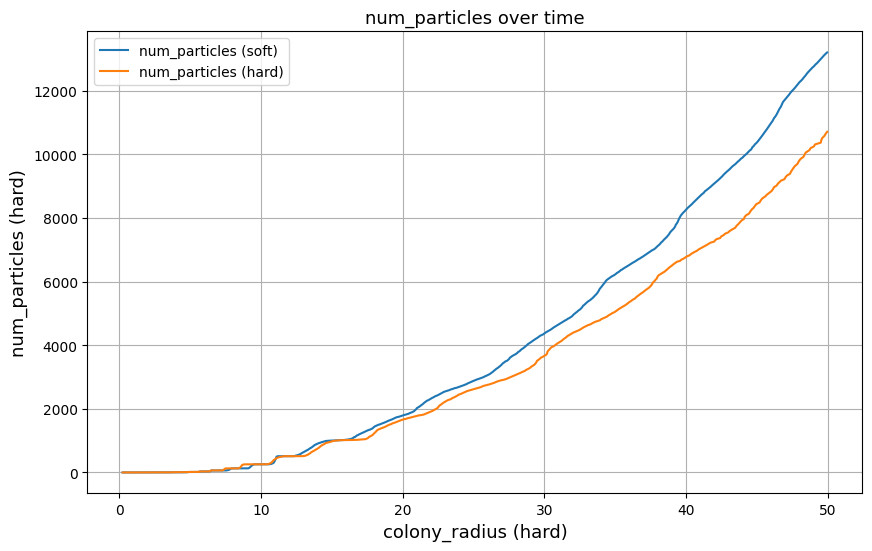

In [220]:
fig = plot_parameter_over_time(
    simulation_soft_all, "colony_radius (soft)", "num_particles (soft)")
fig = plot_parameter_over_time(
    simulation_hard_all, "colony_radius (hard)", "num_particles (hard)", fig=fig)

In [221]:
import seaborn as sns

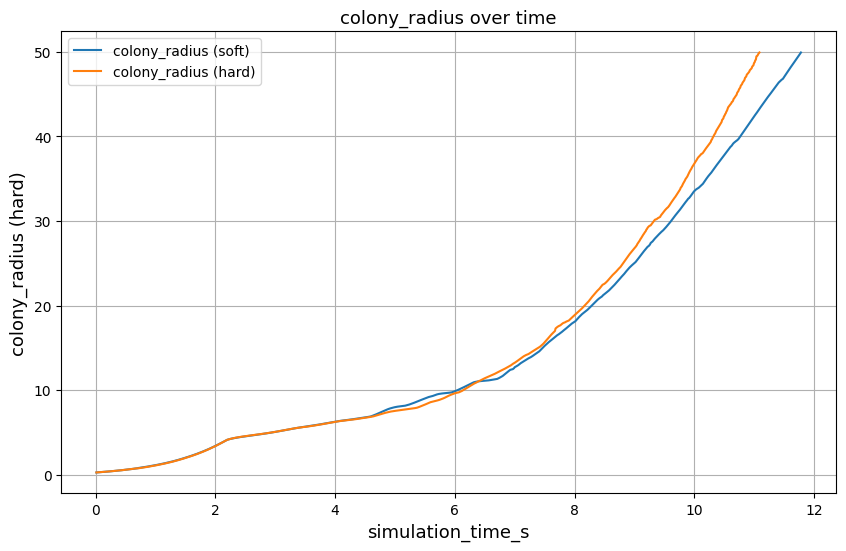

In [222]:
fig = plot_parameter_over_time(simulation_soft_all, "simulation_time_s", "colony_radius (soft)")
fig = plot_parameter_over_time(
    simulation_hard_all, "simulation_time_s", "colony_radius (hard)", fig=fig)

In [223]:

series = simulation_hard_all["mpi_comm_time_s (hard)"]

# series.iloc[1001] = 0.025

In [224]:
simulation_soft_all

,iteration (soft),simulation_time_s,step_duration_s (soft),step (soft),num_particles (soft),num_constraints (soft),colony_radius (soft),recursive_iterations (soft),bbpgd_iterations (soft),max_overlap (soft),...,memory_usage_mb (soft),peak_memory_mb (soft),cpu_time_s (soft),mpi_comm_time_s (soft),load_imbalance (soft),dt_s (soft),x (soft),y (soft),z (soft),rank (soft)
471,0,0.01005,0.000791,200,1,0,0.255050,1,0,0.000000,...,41.4844,41.4844,1.37821,0.000686,16.00000,0.00005,NaN,NaN,NaN,0
806,1,0.02005,0.000756,400,1,0,0.260126,1,0,0.000000,...,41.4844,41.4844,1.58225,0.000559,16.00000,0.00005,NaN,NaN,NaN,0
204,2,0.03005,0.000694,600,1,0,0.265253,1,0,0.000000,...,41.5977,41.5977,1.70799,0.000558,16.00000,0.00005,NaN,NaN,NaN,0
176,3,0.04005,0.000694,800,1,0,0.270431,1,0,0.000000,...,41.5977,41.5977,1.82930,0.000421,16.00000,0.00005,NaN,NaN,NaN,0
651,4,0.05005,0.000692,1000,1,0,0.275661,1,0,0.000000,...,41.5977,41.5977,2.04124,0.000565,16.00000,0.00005,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,1168,11.74310,0.011258,234862,13015,38250,49.516000,1,0,0.238701,...,42.5156,42.5156,849.80300,0.026578,1.37810,0.00005,NaN,NaN,NaN,0
1077,1169,11.75320,0.011108,235063,13069,38446,49.617900,1,0,0.242597,...,42.5156,42.5156,855.49600,0.030762,1.38343,0.00005,NaN,NaN,NaN,0
746,1170,11.76320,0.012625,235264,13116,38559,49.723500,1,0,0.249537,...,42.5156,42.5156,861.12900,0.025345,1.38457,0.00005,NaN,NaN,NaN,0
48,1171,11.77330,0.010703,235465,13163,38703,49.827900,1,0,0.248676,...,42.5156,42.5156,866.67800,0.027339,1.38692,0.00005,NaN,NaN,NaN,0


In [225]:
simulation_hard_all.columns

Index(['iteration (hard)', 'simulation_time_s', 'step_duration_s (hard)',
       'step (hard)', 'num_particles (hard)', 'num_constraints (hard)',
       'colony_radius (hard)', 'recursive_iterations (hard)',
       'bbpgd_iterations (hard)', 'max_overlap (hard)', 'residual (hard)',
       'memory_usage_mb (hard)', 'peak_memory_mb (hard)', 'cpu_time_s (hard)',
       'mpi_comm_time_s (hard)', 'load_imbalance (hard)', 'dt_s (hard)',
       'x (hard)', 'y (hard)', 'z (hard)', 'rank (hard)'],
      dtype='object')

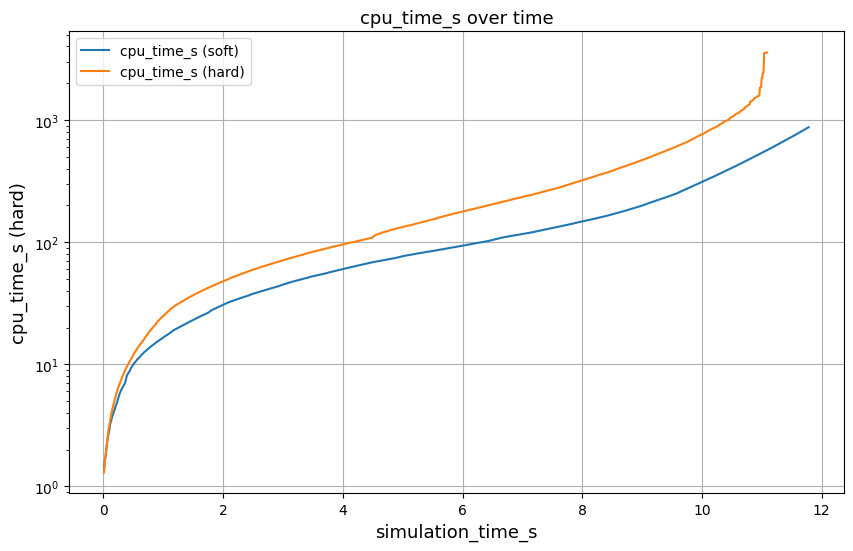

In [226]:
fig = plot_parameter_over_time(simulation_soft_all, "simulation_time_s", "cpu_time_s (soft)")
fig = plot_parameter_over_time(
    simulation_hard_all, "simulation_time_s", "cpu_time_s (hard)", fig=fig)

# set log y axis

fig.axes[0].set_yscale("log")










In [227]:
simulation_soft_all

,iteration (soft),simulation_time_s,step_duration_s (soft),step (soft),num_particles (soft),num_constraints (soft),colony_radius (soft),recursive_iterations (soft),bbpgd_iterations (soft),max_overlap (soft),...,memory_usage_mb (soft),peak_memory_mb (soft),cpu_time_s (soft),mpi_comm_time_s (soft),load_imbalance (soft),dt_s (soft),x (soft),y (soft),z (soft),rank (soft)
471,0,0.01005,0.000791,200,1,0,0.255050,1,0,0.000000,...,41.4844,41.4844,1.37821,0.000686,16.00000,0.00005,NaN,NaN,NaN,0
806,1,0.02005,0.000756,400,1,0,0.260126,1,0,0.000000,...,41.4844,41.4844,1.58225,0.000559,16.00000,0.00005,NaN,NaN,NaN,0
204,2,0.03005,0.000694,600,1,0,0.265253,1,0,0.000000,...,41.5977,41.5977,1.70799,0.000558,16.00000,0.00005,NaN,NaN,NaN,0
176,3,0.04005,0.000694,800,1,0,0.270431,1,0,0.000000,...,41.5977,41.5977,1.82930,0.000421,16.00000,0.00005,NaN,NaN,NaN,0
651,4,0.05005,0.000692,1000,1,0,0.275661,1,0,0.000000,...,41.5977,41.5977,2.04124,0.000565,16.00000,0.00005,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,1168,11.74310,0.011258,234862,13015,38250,49.516000,1,0,0.238701,...,42.5156,42.5156,849.80300,0.026578,1.37810,0.00005,NaN,NaN,NaN,0
1077,1169,11.75320,0.011108,235063,13069,38446,49.617900,1,0,0.242597,...,42.5156,42.5156,855.49600,0.030762,1.38343,0.00005,NaN,NaN,NaN,0
746,1170,11.76320,0.012625,235264,13116,38559,49.723500,1,0,0.249537,...,42.5156,42.5156,861.12900,0.025345,1.38457,0.00005,NaN,NaN,NaN,0
48,1171,11.77330,0.010703,235465,13163,38703,49.827900,1,0,0.248676,...,42.5156,42.5156,866.67800,0.027339,1.38692,0.00005,NaN,NaN,NaN,0


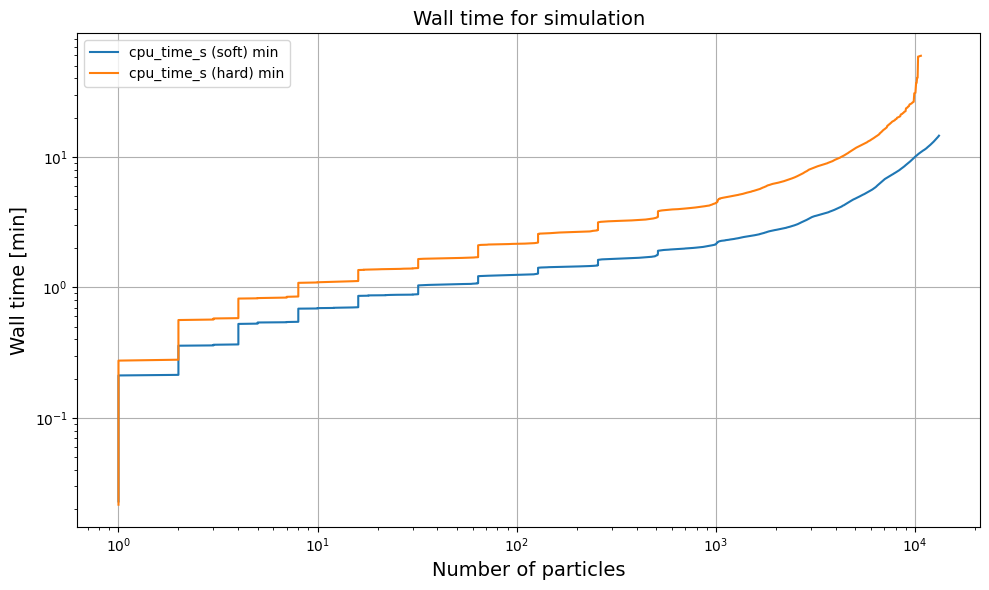

In [228]:
simulation_soft_all["cpu_time_s (soft) min"] = simulation_soft_all["cpu_time_s (soft)"] / 60
simulation_hard_all["cpu_time_s (hard) min"] = simulation_hard_all["cpu_time_s (hard)"] / 60

fig = plot_parameter_over_time(
    simulation_soft_all, "num_particles (soft)", "cpu_time_s (soft) min")
fig = plot_parameter_over_time(
    simulation_hard_all, "num_particles (hard)", "cpu_time_s (hard) min", fig=fig)

# set log y axis

fig.axes[0].set_xlabel("Number of particles", fontsize=14)
fig.axes[0].set_ylabel("Wall time [min]", fontsize=14)

fig.axes[0].set_title("Wall time for simulation", fontsize=14)
ax = fig.axes[0]


fig.axes[0].set_xscale("log")
fig.axes[0].set_yscale("log")

fig.axes[0].legend()


fig.tight_layout()
fig.savefig("wall_time_simulation.png", dpi=300)

In [229]:
(simulation_hard_all["cpu_time_s (hard) min"] / simulation_soft_all["cpu_time_s (soft) min"] ).median()

np.float64(1.7959382835744617)

In [230]:
simulation_hard_all.columns

Index(['iteration (hard)', 'simulation_time_s', 'step_duration_s (hard)',
       'step (hard)', 'num_particles (hard)', 'num_constraints (hard)',
       'colony_radius (hard)', 'recursive_iterations (hard)',
       'bbpgd_iterations (hard)', 'max_overlap (hard)', 'residual (hard)',
       'memory_usage_mb (hard)', 'peak_memory_mb (hard)', 'cpu_time_s (hard)',
       'mpi_comm_time_s (hard)', 'load_imbalance (hard)', 'dt_s (hard)',
       'x (hard)', 'y (hard)', 'z (hard)', 'rank (hard)',
       'cpu_time_s (hard) min'],
      dtype='object')

In [231]:


series = simulation_hard_all["bbpgd_iterations (hard)"]

series.iloc[1001] = 60


# simulation_hard_all["bbpgd_iterations (hard)"].argmax()

# simulation_hard_all["bbpgd_iterations (hard)"]

/tmp/ipykernel_2488361/574759351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.iloc[1001] = 60


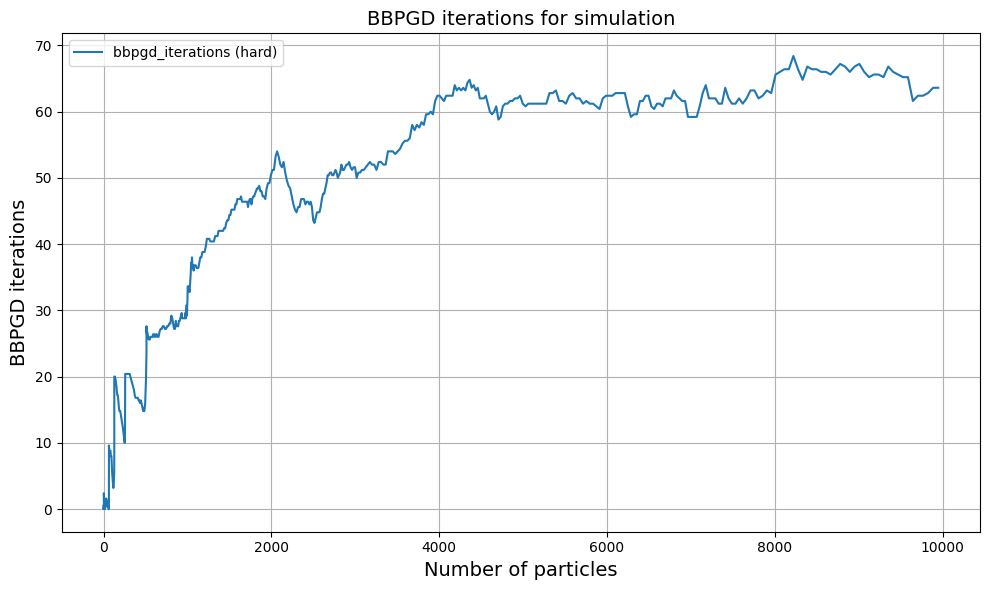

In [232]:

fig = plot_parameter_over_time(
    simulation_hard_all, "num_particles (hard)", "bbpgd_iterations (hard)", rolling_window=25)

# set log y axis

fig.axes[0].set_xlabel("Number of particles", fontsize=14)
fig.axes[0].set_ylabel("BBPGD iterations", fontsize=14)

fig.axes[0].set_title("BBPGD iterations for simulation", fontsize=14)
ax = fig.axes[0]



fig.axes[0].legend()

fig.tight_layout()
fig.savefig("bbpgd_iterations_simulation.png", dpi=300)

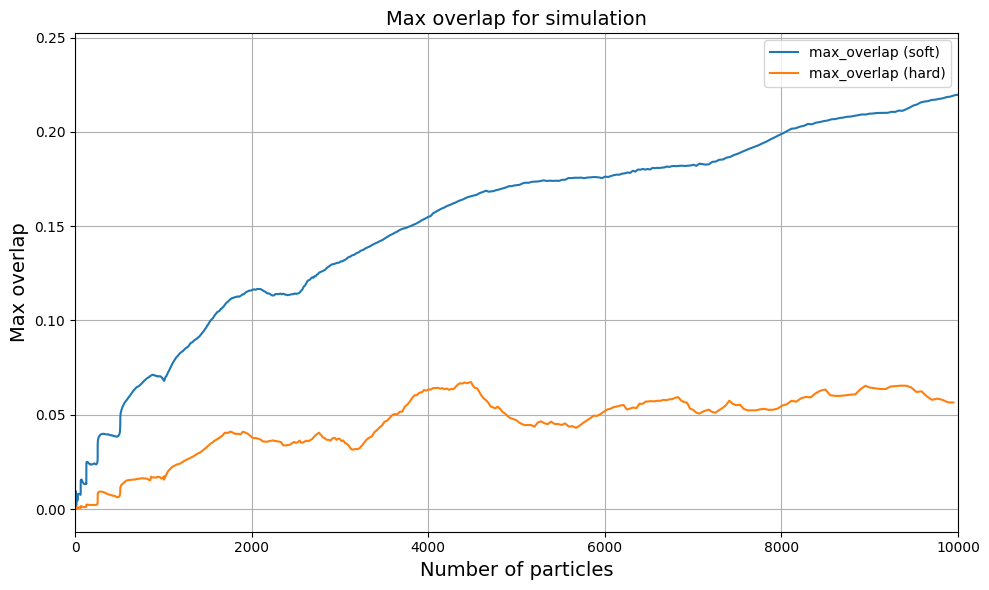

In [233]:

fig = plot_parameter_over_time(
    simulation_soft_all, "num_particles (soft)", "max_overlap (soft)", rolling_window=25)
fig = plot_parameter_over_time(
    simulation_hard_all, "num_particles (hard)", "max_overlap (hard)", fig=fig, rolling_window=25)

# set log y axis

fig.axes[0].set_xlabel("Number of particles", fontsize=14)
fig.axes[0].set_ylabel("Max overlap", fontsize=14)

fig.axes[0].set_title("Max overlap for simulation", fontsize=14)
ax = fig.axes[0]


fig.axes[0].legend()


fig.axes[0].set_xlim(0, 10000)

fig.tight_layout()
fig.savefig("max_overlap_simulation.png", dpi=300)